-------------------------------------------------

This notebook is part of the [q4p (Quantum Computing for Programmers) series](https://github.com/CarloLepelaars/q4p). The original notebook can be found on [Github](https://github.com/CarloLepelaars/q4p/blob/main/nbs/03-multi.ipynb).

-------------------------------------------------

# 3. Multi-qubit gates and algorithms

In previous notebooks we got an extensive overview of how to work with a single qubit. In this notebook we will generalize to multiple qubits and finally look at meaningful algorithms that quantum computing offers. The previous notebooks gave you a solid toolbox from which to construct these algorithms. From here we will focus more on applying gates to construct quantum circuits.

In this lesson you will learn:

- Build and convert quantum circuits with [skq](https://github.com/CarloLepelaars/skq)
- **Bell** and **GHZ** States
- Converting quantum circuits to quantum frameworks like [Qiskit](https://www.ibm.com/quantum/qiskit) and [OpenQASM](https://openqasm.com/intro.html)
- Toffoli ($CCX$) Gate
- Simulating classical $AND$ and $OR$ gates with quantum circuits
- $SWAP$ Gate
- BONUS: Fredkin ($CSWAP$) Gate

# skq

To avoid having to construct gates and concepts from scratch each time we will use the [skq](https://github.com/CarloLepelaars/skq) library. I built this library so you can easily play with quantum concepts (in NumPy) and build your own algorithms. These circuits can then be converted to popular quantum frameworks like [Qiskit](https://github.com/Qiskit/qiskit) and [OpenQASM](https://openqasm.com/intro.html) so you can run them on real quantum computers.

All the quantum logic gates we talked about in previous notebooks can be found in the `skq.gates.qubit` module. We will also heavily use `Concat` for multi-qubit gates and `Circuit` for quantum circuits. These are relatively simple objects, but can be extended to any complex circuit.

In [1]:
# Kaleido is used to convert Plotly to static png
!pip install -Uqq kaleido
# skq is used to build quantum circuits
!pip install -Uqq skq

In [2]:
import numpy as np

from skq.gates.qubit import X, H, I, CX, CCX, SWAP, CSwap, Measure
from skq.circuits import Concat, Circuit, BellStates, GHZStates

import plotly.graph_objects as go

# Fix Plotly rendering in Jupyter forks.
# If you are running this notebook locally you can comment this out.
# This allows you to play with interactive Plotly plots.
import plotly.io as pio
pio.renderers.default = 'png'

## Bell State

One of the first breakthroughs for quantum computing was the implementation of a completely entangled state called the **Bell state**. In this state 2 qubits are 100% correlated to each other. This enables use cases that are not possible classically, like [quantum communication](https://en.wikipedia.org/wiki/Quantum_channel) and [quantum teleportation](https://en.wikipedia.org/wiki/Quantum_teleportation).

The traditional Bell State is called the **Phi Plus state** ($| \Phi^+ \rangle$) and is defined as follows:

$$
| \Phi^+ \rangle = \frac{1}{\sqrt{2}} (|00\rangle + |11\rangle)
$$

To prepare entanglement we first initialize two qubits ($|00 \rangle = [1, 0, 0, 0]$) and put the 1st qubit in superposition with a Hadamard ($H$) gate. The 1st qubit is not changed in this first step so the $I$ gate is applied.

Initial state:
$$
|\psi_0 \rangle = |00 \rangle
$$

After applying the Hadamard ($H$) gate:
$$
|\psi_1 \rangle = \frac{1}{\sqrt{2}} (|00 \rangle + |10 \rangle)
$$

Note that the 1st qubit is either 0 or 1 with equal probability, but the 2nd qubit is always 0. This leaves the possible states $|00 \rangle$ and $|10 \rangle$ with equal probability in this intermediate state.

To accomplish this operation in `skq` let's take a look at the `Concat` object. We use `Concat` to concatenate gates for multiple qubits. To obtain the concatenated operation the Kronecker product $\otimes$ is used.

In [3]:
step1 = Concat([H(), I()])

In [4]:
# Transformation on a 2 qubit system that puts the first qubit in superposition
np.kron(H(), I())

H([[ 0.70710678+0.j,  0.        +0.j,  0.70710678+0.j,  0.        +0.j],
   [ 0.        +0.j,  0.70710678+0.j,  0.        +0.j,  0.70710678+0.j],
   [ 0.70710678+0.j,  0.        +0.j, -0.70710678+0.j, -0.        +0.j],
   [ 0.        +0.j,  0.70710678+0.j, -0.        +0.j, -0.70710678+0.j]])

The result of a concatenation is not just stacking $2$ matrices, but a new matrix that is applied to a $2$-qubit state. The concatenation of $2$ single qubit gates results in a $4 \times 4$ matrix. This grows exponentially with the number of qubits. For example, concatenating $3$ single qubit gates results in a $2^3 \times 2^3 = 8 \times 8$ matrix. In this notebook we will encounter fundamental 3-qubit gates that cannot be decomposed into single qubit gates, like the Toffoli ($CCX$) gate. It is important to treat multi-qubits systems as a single unit, because they are potentially entangled. This is an important difference compared to classical computing, where individual bits do not depend on each other.

In [5]:
output1 = step1([1, 0, 0, 0])
# Superposition between |00> and |10>
output1

H([0.70710678+0.j, 0.        +0.j, 0.70710678+0.j, 0.        +0.j])

We have learned that every qubit gate can also be applied in reverse, so also with `Concat`.

In [6]:
# Transforms superposition of |00> and |10> back to |00>
step1.decodes(output1).round(8)

H([ 1.+0.j,  0.+0.j, -0.+0.j,  0.+0.j])

For the Bell state the two qubits are then entangled using the CNOT ($CX$) gate. This results in a fully entangled state of 2 qubits. The individual qubits cannot be visualized nicely on a Bloch sphere anymore, because the state of the qubits depend on each other. It is like flipping 2 coins at the same time, but the outcome will be either 2 heads or 2 tails.

The intermediate state we had before the $CX$ gate is:
$$
|\psi_1 \rangle = \frac{1}{\sqrt{2}} (|00 \rangle + |10 \rangle)
$$

After the $CX$ gate we obtain the final Bell state:
$$
|\psi_2\rangle = CX \frac{1}{\sqrt{2}} (|00 \rangle + |10 \rangle) = \frac{1}{\sqrt{2}} (|00 \rangle + CX|10 \rangle) = \frac{1}{\sqrt{2}} (|00 \rangle + |11 \rangle) = | \Phi^+ \rangle
$$

The operation flips the second qubit only if the first qubit is 1. 

In [7]:
step2 = CX()
# Bell state Phi Plus: Superposition between |00> and |11>
step2(step1([1, 0, 0, 0]))

array([0.70710678+0.j, 0.        +0.j, 0.        +0.j, 0.70710678+0.j])

These qubits can be separated over large distances and can enable secure communication, among other things.

Now let's construct the complete circuit and verify that we implemented the Bell state correctly. `Circuit` allows us to run quantum operations in sequence. It also has functionality to convert to popular quantum frameworks like [Qiskit](https://github.com/Qiskit/qiskit) and [OpenQASM](https://openqasm.com/intro.html). At the end of the `Circuit` we add a `Measure` step to obtain a probability distribution of possible outcomes.

In [8]:
bell_circuit = Circuit([step1, step2, Measure()])
bell_probs = bell_circuit([1, 0, 0, 0])
# 50% probability of 00 and 50% probability of 11
bell_probs

array([0.5, 0. , 0. , 0.5])

Recall that measurement is achieved by sampling from the probability distribution. You will see that the only possible outcomes are $00$ and $11$ and they are roughly evenly distributed. Be aware that on real quantum computers are noisy so there is a small chance of still measuring $01$ or $10$.

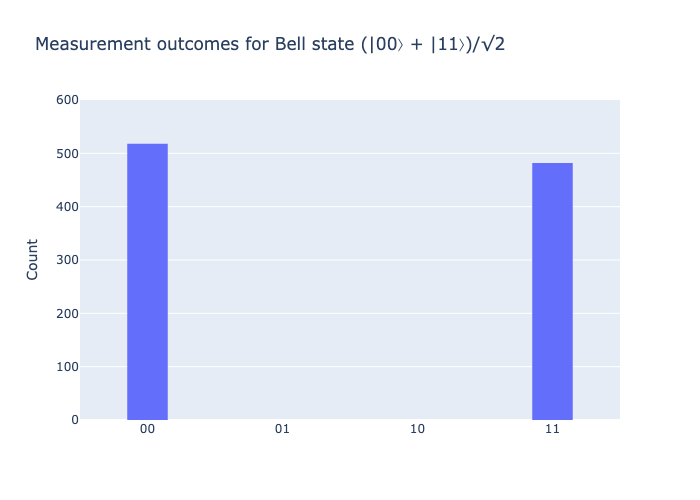

In [9]:
# Sample the Bell state 1000 times
samples = [np.random.choice([0, 1, 2, 3], p=bell_probs) for _ in range(1000)]

fig = go.Figure()
fig.add_trace(go.Histogram(
    x=samples,
    xbins=dict(
        start=-0.5,
        end=3.5,
        size=1
    ),
))
fig.update_layout(
    title="Measurement outcomes for Bell state (|00⟩ + |11⟩)/√2",
    xaxis=dict(
        tickmode="array",
        tickvals=[0, 1, 2, 3],
        ticktext=["00", "01", "10", "11"]
    ),
    yaxis=dict(
        title="Count",
        range=[0, 600]
    ),
    bargap=0.7
)
fig.show()

In `skq` we can directly intialize the Bell states as a building block in our circuits.

In [10]:
phi_plus = BellStates().circuit(1)

bell_state1 = phi_plus([1,0,0,0])
# Superposition between |00> and |11>
bell_state1

array([0.70710678+0.j, 0.        +0.j, 0.        +0.j, 0.70710678+0.j])

A convenient feature of `skq` `Circuit` is conversion to `Qiskit`. A `Qiskit` `QuantumCircuit` can be run on a real IBM quantum computer and offers nice visualization methods.

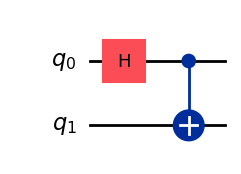

In [11]:
phi_plus.convert(framework="qiskit").draw(output="mpl")

In total there are $4$ Bell states, but the outcomes of the 'Plus' and 'Minus' states are the same, even though they are different circuits. For simplicity the conversion process from `skq` to `Qiskit` will remove any Identity ($I$) gates. `Circuit.draw` uses Qiskit's circuit visualization under the hood.

In [12]:
bell = BellStates()
for i, name in enumerate(["Phi Plus (|Φ+⟩). Entangles |00⟩ and |11⟩.", 
                          "Phi Minus (|Φ-⟩). Entangles |00⟩ and |11⟩ with opposite phase.", 
                          "Psi Plus (|Ψ+⟩). Entangles |01⟩ and |10⟩.", 
                          "Psi Minus (|Ψ-⟩). Entangles |01⟩ and |10⟩ with opposite phase."], 
                          start=1):
    circuit = bell.circuit(i)
    print(f"Bell state {i}: {name}")
    print(circuit.draw())

Bell state 1: Phi Plus (|Φ+⟩). Entangles |00⟩ and |11⟩.
     ┌───┐     
q_0: ┤ H ├──■──
     └───┘┌─┴─┐
q_1: ─────┤ X ├
          └───┘
Bell state 2: Phi Minus (|Φ-⟩). Entangles |00⟩ and |11⟩ with opposite phase.
     ┌───┐     ┌───┐
q_0: ┤ H ├──■──┤ Z ├
     └───┘┌─┴─┐└───┘
q_1: ─────┤ X ├─────
          └───┘     
Bell state 3: Psi Plus (|Ψ+⟩). Entangles |01⟩ and |10⟩.
     ┌───┐     
q_0: ┤ H ├──■──
     ├───┤┌─┴─┐
q_1: ┤ X ├┤ X ├
     └───┘└───┘
Bell state 4: Psi Minus (|Ψ-⟩). Entangles |01⟩ and |10⟩ with opposite phase.
     ┌───┐┌───┐     
q_0: ┤ H ├┤ Z ├──■──
     ├───┤├───┤┌─┴─┐
q_1: ┤ X ├┤ Z ├┤ X ├
     └───┘└───┘└───┘


Often it will be clearer to use the [Matplotlib](https://matplotlib.org) circuit visualization that Qiskit offers. Define `output="mpl"` to use this.

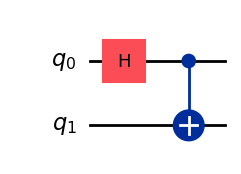

In [13]:
phi_plus.draw(output="mpl")

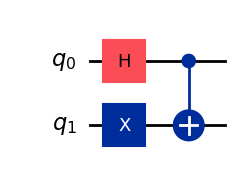

In [14]:
psi_plus = BellStates().circuit(3)
psi_plus.draw(output="mpl")

Another popular standard for defining quantum circuits is [OpenQASM](https://openqasm.com/intro.html). You can think of OpenQASM as assembly language for quantum computers. We will devote a separate notebook to go more in-depth into OpenQASM. For now be aware that many providers of quantum computers support OpenQASM. We can convert `skq` circuits to an OpenQASM program (string). 

In [15]:
print(psi_plus.convert(framework="qasm"))

OPENQASM 2.0;
include "qelib1.inc";
qreg q[2];
h q[0];
x q[1];
cx q[0], q[1];


Adding a `Measure` step will include measurement to the end of the circuit for all qubits.

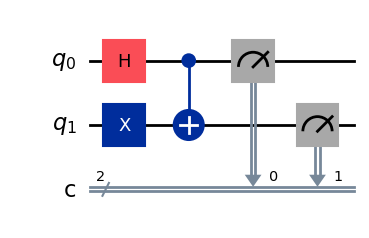

In [16]:
psi_plus_with_measure = Circuit([*psi_plus, Measure()])
psi_plus_with_measure.draw(output="mpl")

In [17]:
print(psi_plus_with_measure.convert(framework="qasm"))

OPENQASM 2.0;
include "qelib1.inc";
qreg q[2];
creg c[2];
h q[0];
x q[1];
cx q[0], q[1];
measure q[0] -> c[0];
measure q[1] -> c[1];


## GHZ State

A **GHZ (Greenberger-Horne-Zeilinger) State** generalizes the notion of a Bell state to $n$ qubits. This creates a fully entangled state between all qubits.

Let's for example take a 3-qubit GHZ state. It is defined as:

$$
GHZ_3 = \frac{1}{\sqrt{2}}(|000\rangle + |111\rangle)
$$



In [18]:
ghz_3 = GHZStates().circuit(n_qubits=3)
# 50% probability of |000> and 50% probability of |111>
ghz_3([1,0,0,0,0,0,0,0])

H([0.70710678+0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j,
   0.        +0.j, 0.        +0.j, 0.        +0.j, 0.70710678+0.j])

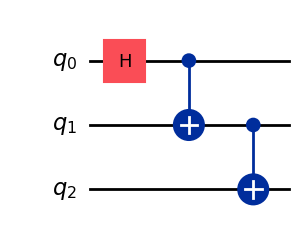

In [19]:
ghz_3.draw(output="mpl")

If you look closely you will see a pattern of $CX$ gates all the way down. The first qubit determines the state of all the other qubits. We can do this on an arbitrary number of qubits. For example, see the 10-qubit GHZ state below.

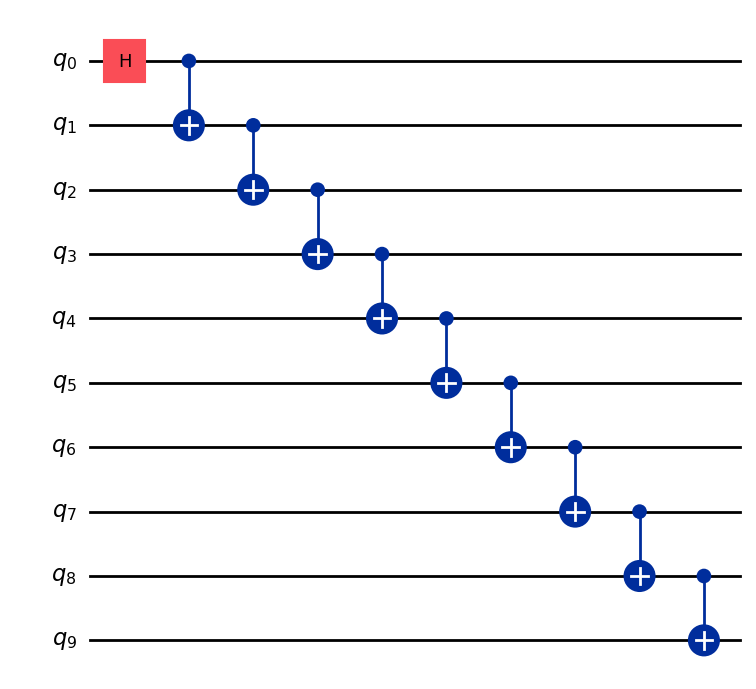

In [20]:
n_ghz_qubits = 10

ghz = GHZStates().circuit(n_qubits=n_ghz_qubits)
ghz.draw(output="mpl")


I invite you to play with this circuit and change the number of qubits with `n_ghz_qubits`. Remember that the matrices grow exponentially with the number of qubits, so even a GHZ state with 15 qubits may take quite a while to compute on your machine. This is why we want to leverage real quantum computers to scale computations with entanglement.


The OpenQASM program for the GHZ state gives another perspective and makes it clear how the first qubit entangles with all the other qubits.

In [21]:
print(ghz.convert(framework="qasm"))

OPENQASM 2.0;
include "qelib1.inc";
qreg q[10];
h q[0];
cx q[0], q[1];
cx q[1], q[2];
cx q[2], q[3];
cx q[3], q[4];
cx q[4], q[5];
cx q[5], q[6];
cx q[6], q[7];
cx q[7], q[8];
cx q[8], q[9];


This concludes our discussion of the Bell states and GHZ states. The rest of this lesson will cover some fundamental multi-qubit gates and how it enables us to simulate classical $AND$ and $OR$ gates.

## CCX (Toffoli) Gate

A $CCX$ (Toffoli) gate is like a $CNOT$ gate, but for $3$ qubits. If the first $2$ (control) qubits are $1$, the third (target) qubit is flipped. A $3$-qubit gate requires a $2^3 \times 2^3 = 8 \times 8$ matrix to represent classically.


$$CCX = \begin{bmatrix}
1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 \\
0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 \\
\end{bmatrix}
$$


In [22]:
CCX()

CCX([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
     [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
     [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
     [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
     [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
     [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
     [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
     [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j]])

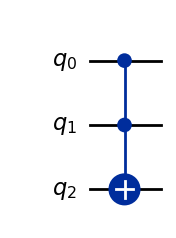

In [23]:
CCX().draw(output="mpl")

A $CCX$ will transform a $|110\rangle$ state into a $|111\rangle$ state.

$$
CCX|110\rangle = \begin{bmatrix}
1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 \\
0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 \\
\end{bmatrix} \begin{bmatrix}0\\0\\0\\0\\0\\0\\1\\0\end{bmatrix} = \begin{bmatrix}0\\0\\0\\0\\0\\0\\0\\1\end{bmatrix} = |111\rangle
$$

In [24]:
CCX() @ [0,0,0,0,0,0,1,0]

CCX([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j])

$|111\rangle$ will be transformed into a $|110\rangle$ state.
$$
CCX|111\rangle = 
 \begin{bmatrix}
1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 \\
0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 \\
\end{bmatrix}\begin{bmatrix}0\\0\\0\\0\\0\\0\\0\\1\end{bmatrix} = \begin{bmatrix}0\\0\\0\\0\\0\\0\\1\\0\end{bmatrix} = |110\rangle
$$

In [25]:
CCX() @ [0,0,0,0,0,0,0,1]

CCX([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j])

## Simulating AND and OR gates

Note that the Toffoli gate behaves similarly to an $AND$ gate in classical computing. In fact, classical $AND$ and $OR$ gates can be simulated using only $CCX$ and $X$ gates.

#### $AND$ gate

Performing an $AND$ in a quantum circuit takes 3 qubits. After the $CCX$ gate the third qubit will represent the $AND$ of the first two qubits. The first two qubits remain unchanged after the $CCX$ gate.
```
|a>: ──■── |a>
       │  
|b>: ──■── |b>
     ┌─┴─┐
|0>: ┤ X ├ |a ∧ b>
     └───┘
```
$\land$ = AND


A Toffoli gate can be represented in quantum circuits like this:

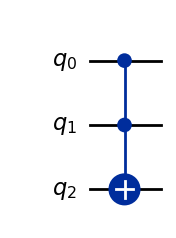

In [26]:
and_gate = CCX()
and_gate.draw(output="mpl")

#### $OR$ gate

A $OR$ gate can also be simulated using 3 qubits. The trick is to first flip the first two qubits with an $X$, before applying the $CCX$ gate. Then to retrieve the $OR$ in the third qubit we apply another $X$ gate on the third qubit. Note that this changes the state of the first 2 qubits, which represent the $NOT$ of $a$ and $b$ after the operation. To get back the original state of $|a>$ and $|b>$ we would need to apply $X$ to the first 2 qubits again after the $OR$ gate.


```
     ┌───┐          
|a>: ┤ X ├──■─────── |¬a>
     ├───┤  │       
|b>: ┤ X ├──■─────── |¬b>
     └───┘┌─┴─┐┌───┐
|0>: ─────┤ X ├┤ X ├ |a ∨ b>
          └───┘└───┘
```
$\neg$ = NOT

$\lor$ = OR

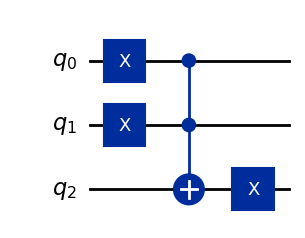

In [27]:
or_gate = Circuit([Concat([X(), X(), I()]), 
                   CCX(),
                   Concat([I(), I(), X()])])
or_gate.draw(output="mpl")

In [28]:
# |100> -> OR -> |001>
or_gate([0,1,0,0,0,0,0,0])


I([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j])

I leave it as an exercise to you to make a quantum circuit that implements an $OR$ gate, but where the first 2 qubits keep their original state. It should transform $100\rangle$ -> $|101\rangle$.

If you like a challenge, think about generalizing this $OR$ gates to $n$ qubits. 

And what would an $XOR$ gate look like? HINT: $XOR$ is simpler than you think. It involves only $CCX$ gates.

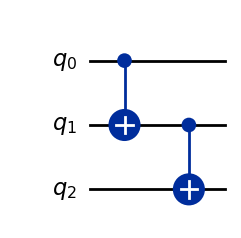

In [29]:
xor_gate = Circuit([
    Concat([CX(), I()]),
    Concat([I(), CX()]),
])
xor_gate.draw(output="mpl")

## SWAP

Quantum computers have a limited amount of qubit registers. Qubits that are far apart from each other can also become unstable. In larger quantum circuits it is necessary to move qubits around into different registers. We can achieve this by swapping qubits. The $SWAP$ gate swaps $2$ qubits.


$$SWAP = \begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 0 & 1 \\
\end{bmatrix}
$$

In [30]:
SWAP()

SWAP([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
      [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
      [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
      [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j]])

$$SWAP|01\rangle =
 \begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 0 & 1 \\
\end{bmatrix} \begin{bmatrix}0\\1\\0\\0\end{bmatrix} =  \begin{bmatrix}0\\0\\1\\0\end{bmatrix} = |10\rangle
$$


In [31]:
# |01> -> SWAP -> |10>
[0,1,0,0] @ SWAP()

SWAP([0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j])

A $SWAP$ gate is represented in quantum circuits like this:

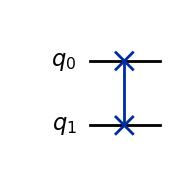

In [32]:
SWAP().draw(output="mpl")

$SWAP$ gates are most often used in [transpilation](https://docs.quantum.ibm.com/guides/transpile). **Transpilation** is an automated process which optimizes a quantum circuit for a specific quantum computer. The process is very similar to how compilers work for classical computers. Modern quantum transpilers will utilize Machine Learning (ML) models for more efficient optimization of circuits. Further in the course we will dive deeper into transpilation. For now you don't have to worry about it as quantum computing providers have developed efficient transpilers you can use.

## BONUS: CSWAP (Fredkin) Gate

Practically any gate we have discussed so far can be extended to a controlled version. There can also be an arbitrary numbers of **control and target qubits**. A controlled gate you may encounter in the wild is the Controlled-SWAP gate ($CSWAP$), also known as the **Fredkin** gate. This gate has **1 control qubit** (determines if the gate is applied or not) and **2 target qubits** (qubits that are swapped).

$$CSWAP = \begin{bmatrix}
1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 \\
\end{bmatrix}
$$


In [33]:
CSwap()

CSwap([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j]])

In the example below we see that the second and third (target) qubits are swapped, because the first (control) qubit is $1$.

$$CSWAP|110\rangle = 
\begin{bmatrix}
1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 \\
\end{bmatrix} \begin{bmatrix}0\\0\\0\\0\\0\\1\\0\\0\end{bmatrix} = \begin{bmatrix}0\\0\\0\\0\\0\\0\\1\\0\end{bmatrix} = |101\rangle
$$

In [34]:
# |110> -> CSWAP -> |101>
CSwap() @ [0,0,0,0,0,1,0,0]

CSwap([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j])

This is what a $CSWAP$ gate looks like in quantum circuits:

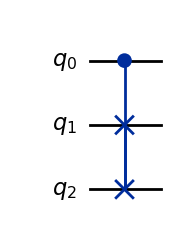

In [35]:
CSwap().draw(output="mpl")

With these tools in your toolbox you are ready to build almost any quantum circuit. Subsequent lessons will therefore mostly focus on implementing practical quantum algorithms. We will also discuss the challenges we face with scaling these algorithms on real quantum computers.

Continue with the next lesson:
- [On Github](https://github.com/CarloLepelaars/q4p/blob/main/nbs/04-deutsch.ipynb)
- [On Kaggle](https://www.kaggle.com/code/carlolepelaars/q4p-4-deutsch-josza)

-------------------------------------------------

This notebook is part of the [q4p (Quantum Computing for Programmers) series](https://github.com/CarloLepelaars/q4p). The original notebook can be found on [Github](https://github.com/CarloLepelaars/q4p/blob/main/nbs/03-multi.ipynb).

-------------------------------------------------